In [1]:
# Yuxin Lu, Howard Wu, Mercury Liu, Yanice Yin
import numpy as np
import pandas as pd
import os
from feature_extraction import read_emg_data, preprocess_emg, extract_features
import matplotlib.pyplot as plt

data preprocessing

In [2]:
start_root = 'dataset'
# only consider right hands
folders_names = [foldername for foldername in os.listdir(start_root) if '_r_' in foldername]
X = list()
y = list()

# all possible gestures
codomains = ['paper', 'rock', 'scissors']

# better tracking back the file name
idices_to_filepaths_dict = dict()
count = 0

for foldername in folders_names:
    folder_path = os.path.join(start_root, foldername)
    for filename in os.listdir(folder_path):
        # only care about emg files
        if 'emg' not in filename:
            continue
        # extract the gt label from the filename
        y += [labelIdx for labelIdx, labelname in enumerate(codomains) if labelname in filename]
        # extract features
        file_path = os.path.join(folder_path, filename)
        idices_to_filepaths_dict[count] = file_path
        raw_data = read_emg_data(file_path)
        filtered_data = preprocess_emg(raw_data.values)
        features = extract_features(filtered_data.T)
        X.append(features)
        count += 1

# prepare the data to make it ready for training and testing
X = np.array(X)
X = X.reshape(X.shape[0], -1)
y = np.array(y)
count_labels = dict()
for label in y:
    count_labels[label] = count_labels.get(label, 0) + 1

# verify whether the data is handled correctly
print(X.shape)
print(X.reshape(X.shape[0], -1).shape)
print(X[0])
print(y[0])

# verify whether the dataset is balanced
print(count_labels)


(1710, 56)
(1710, 56)
[2.27591847e+03 7.68869529e+03 1.34665242e+04 2.74055487e+03
 1.48398911e+03 9.62779070e+03 9.21911786e+03 3.04446265e+03
 6.33960576e+00 2.14169785e+01 3.75112095e+01 7.63385759e+00
 4.13367440e+00 2.68183585e+01 2.56799940e+01 8.48039734e+00
 2.80682070e+04 3.22770122e+05 8.72890139e+05 4.25620788e+04
 1.09380760e+04 5.61188659e+05 5.34648097e+05 5.98904299e+04
 1.20010227e+02 1.02704651e+02 1.27374577e+02 1.11259459e+02
 1.22835981e+02 1.13999332e+02 1.11006089e+02 1.15239789e+02
 2.84042793e+02 2.87589038e+02 2.62050384e+02 2.72500209e+02
 2.62864004e+02 3.11569942e+02 3.09335004e+02 2.53995371e+02
 7.81818938e+01 8.99080903e+02 2.43139859e+03 1.18554712e+02
 3.04679696e+01 1.56319961e+03 1.48927032e+03 1.66825632e+02
 8.84219546e+00 2.99846814e+01 4.93097237e+01 1.08884031e+01
 5.51979874e+00 3.95373192e+01 3.85910672e+01 1.29161027e+01]
0
{0: 570, 1: 570, 2: 570}


Principal Components Analysis

[0.56597523 0.198884  ]


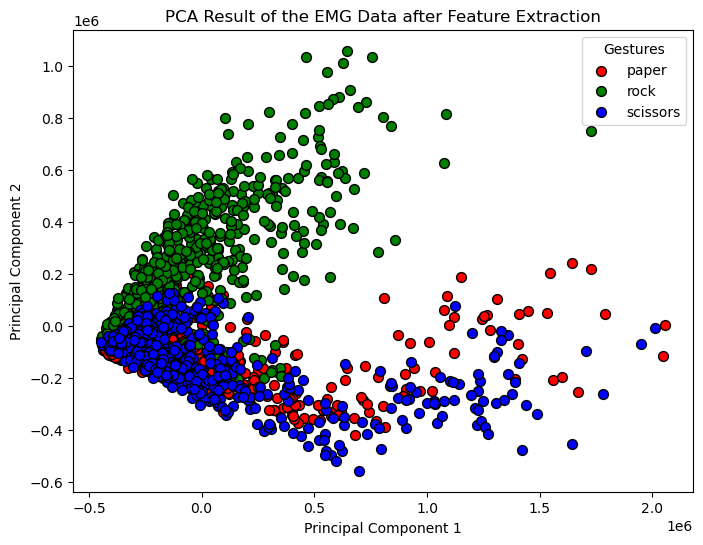

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.datasets import make_classification


# PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
# plotting the result
plt.figure(figsize=(8, 6))
colors = ['red', 'green', 'blue']

for color, label, class_id in zip(colors, codomains, range(3)):
    plt.scatter(X_pca[y == class_id, 0], X_pca[y == class_id, 1], c=color, label=label, edgecolor='k', s=50)


plt.title('PCA Result of the EMG Data after Feature Extraction')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Gestures')
plt.show()


a toy example on how to play with the dataset with a selected model

In [6]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import xgboost as xgb


np.random.seed(2024)
idices = list(range(y.shape[0]))
np.random.shuffle(idices)

train_idices = idices[:int(len(idices)*0.2)]
remain_idices = idices[int(len(idices)*0.2):]


clf = xgb.XGBClassifier(random_state=2024)
clf.fit(X[train_idices], y[train_idices])
y_pred = clf.predict(X[remain_idices])

print(accuracy_score(y[remain_idices], y_pred))
# SVC: 0.6703
# RandomForest: 0.8224
# GaussianNB: 0.6170
# XGBoost: 0.8194



0.8194444444444444


the multi-threads simulator

In [21]:
import threading
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import xgboost as xgb

INIT_SIZE = int(0.1*(y.shape[0]))
BATCH_SIZE = 3

# function to simulate a process that return the performance record based on a random seed
def process(random_seed):
    np.random.seed(random_seed)
    idices = list(range(y.shape[0]))
    np.random.shuffle(idices)

    # initialize
    train_idices = np.array(idices[:INIT_SIZE])
    test_idices = np.array(idices[INIT_SIZE:])

    test_diversity_batch_per_seed = list()
    points_selected = list()

    while (float(len(train_idices))/len(test_idices) < 0.5):

        clf = xgb.XGBClassifier(random_state=random_seed)
        clf.fit(X[train_idices], np.ravel(y[train_idices]))
        y_pred = clf.predict(X[test_idices])
        test_diversity_batch_per_seed.append(accuracy_score(np.ravel(y[test_idices]), y_pred))

        # select the next batch to mv from test to train
        kmeans = KMeans(n_clusters=BATCH_SIZE, random_state=random_seed).fit(X[test_idices])

        # cluster labels for each point (NOTE: it is the index of indices)
        labels = kmeans.labels_

        # for the batch, each from a different cluster
        selected_idices = list()
        for i in range(BATCH_SIZE):
            cluster_indices = np.where(labels == i)[0]
            # randomly select one index
            selected_idices.append(np.random.choice(cluster_indices))
        elements_to_move = test_idices[selected_idices]
        test_idices = np.delete(test_idices, selected_idices)
        train_idices = np.append(train_idices, elements_to_move)

    return test_diversity_batch_per_seed, points_selected

# thread function to execute the process and append the result to a list
def thread_function(seed, results, selected_dict, lock):
    result, points_selected = process(seed)
    with lock:
        results.append(result)
        selected_dict[seed] = points_selected

def main():
    num_threads = 10
    test_diversity_batch_all = []
    threads = []
    selected_dict = {}
    lock = threading.Lock()

    # create and start threads
    for i in range(num_threads):
        thread = threading.Thread(target=thread_function, args=(i, test_diversity_batch_all, selected_dict, 
                                                                lock))
        threads.append(thread)
        thread.start()

    # wait for all threads to complete
    for thread in threads:
        thread.join()

    # calculate and print the mean of the results
    test_diversity_batch_all = np.array(test_diversity_batch_all)
    test_mean_diversity_batch = np.mean(test_diversity_batch_all, axis=0)
    test_std_diversity_batch = np.std(test_diversity_batch_all, axis=0)
    return test_mean_diversity_batch, test_std_diversity_batch, selected_dict



In [ ]:
import matplotlib.pyplot as plt
import pickle

# obtain the results
test_mean_diversity_batch, test_std_diversity_batch, selected_diversity = main()

# plot the results
plt.figure(figsize=(20, 4))

plt.errorbar(np.arange(test_mean_diversity_batch.shape[0]),
             test_mean_diversity_batch,
             yerr=test_std_diversity_batch,
             fmt='s',
             color='steelblue',
             ecolor='steelblue',
             linestyle='--',
             capsize=1,
             markersize=1,
             label='test accuracy of diversity batch selection method')

# to display the legend
plt.legend()

# set up the characteristics of the plot

plt.xlabel('Round Number')
plt.ylabel('Accuracy')
plt.title('Performance for diversity batch active learning in each round with XGBoost')
plt.grid(True, linestyle='--')

# can save the fig to a folder
# plt.savefig('./imgs/e1_NB.png')
plt.show()


passive learning as a benchmark

In [25]:
import threading
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import xgboost as xgb

INIT_SIZE = int(0.1*(y.shape[0]))
BATCH_SIZE = 3

# function to simulate a process that generates a float number based on a random seed
def process_passive(random_seed):
    np.random.seed(random_seed)
    idices = list(range(y.shape[0]))
    np.random.shuffle(idices)

    # initialize
    train_idices = idices[:INIT_SIZE]
    test_idices = idices[INIT_SIZE:]

    test_passive_per_seed = list()
    selected_pts = list()

    while (float(len(train_idices))/len(test_idices) < 0.5):

        clf = xgb.XGBClassifier(random_state=random_seed)
        clf.fit(X[train_idices], np.ravel(y[train_idices]))
        y_pred = clf.predict(X[test_idices])
        test_passive_per_seed.append(accuracy_score(np.ravel(y[test_idices]), y_pred))

        # select the next batch to mv from test to train
        # for passive learning, randomly select
        # and for the batch, each from a different cluster
        for i in range(BATCH_SIZE):
            train_idices = idices[:len(train_idices)+1]
            test_idices = idices[len(train_idices):]
            selected_pts.append(train_idices[-1])

    return test_passive_per_seed, selected_pts

# thread function to execute the process and append the result to a list
def thread_passive(seed, results, pts_dict, lock):
    result, selected_pts = process_passive(seed)
    with lock:
        results.append(result)
        pts_dict[seed] = selected_pts

def main_passive():
    num_threads = 10
    test_passive_all = []
    pts_dict = dict()
    threads = []
    lock = threading.Lock()

    # create and start threads
    for i in range(num_threads):
        thread = threading.Thread(target=thread_passive, args=(i, test_passive_all, pts_dict, lock))
        threads.append(thread)
        thread.start()

    # wait for all threads to complete
    for thread in threads:
        thread.join()

    # calculate and print the mean of the results
    test_passive_all = np.array(test_passive_all)
    test_mean_passive_batch = np.mean(test_passive_all, axis=0)
    test_std_passive_batch = np.std(test_passive_all, axis=0)
    return test_mean_passive_batch, test_std_passive_batch, pts_dict



[0.74860299 0.75110677 0.75257665 0.75470588 0.75428946 0.75912073
 0.75542406 0.75869565 0.7570297  0.75562169 0.75619616 0.76049137
 0.76001331 0.76133333 0.76138945 0.76465863 0.76586184 0.77123656
 0.77239057 0.77422402 0.77342799 0.77350949 0.77569586 0.77768707
 0.77668712 0.78114754 0.77700205 0.78381344 0.78742268 0.78588154
 0.78799172 0.78755187 0.78995149 0.78972222 0.79053584 0.79072524
 0.79336129 0.7912465  0.79410526 0.79606188 0.79351656 0.79887006
 0.79964614 0.79978723 0.80028429 0.8011396  0.80078515 0.80414878
 0.80630824 0.80596264 0.80280778 0.80548341 0.80267534 0.80376812
 0.80624546 0.80691412 0.80547046 0.80804094 0.80747253 0.80800294
 0.81000736 0.80973451 0.81042129 0.81237037 0.81343727 0.81584821
 0.81469053 0.81487294 0.8188764  0.81561562 0.82091798 0.81930618
 0.82131519 0.82068182 0.82194381 0.82359209 0.82135774 0.82255352
 0.82398467 0.82580645 0.82625096 0.8283179  0.82923434 0.82891473
 0.82564103 0.82694704 0.82630757 0.82816901 0.82901961 0.8290

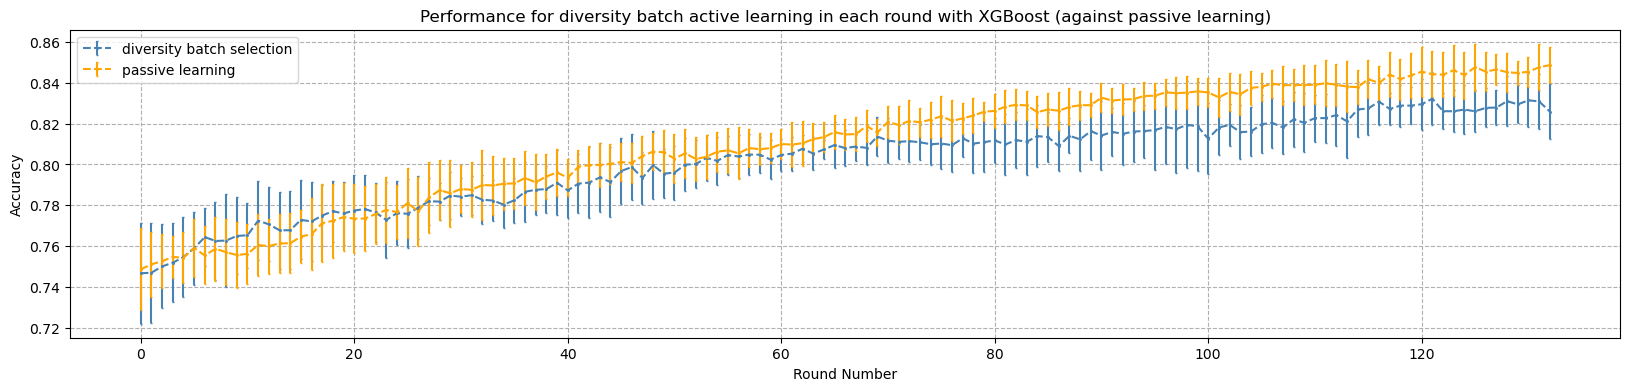

In [26]:
# get the result for passive learning
test_mean_passive_batch, test_std_passive_batch, pts_passive = main_passive()

# plot the results so far
plt.figure(figsize=(20, 4))

plt.errorbar(np.arange(test_mean_diversity_batch.shape[0]),
             test_mean_diversity_batch,
             yerr=test_std_diversity_batch,
             fmt='s',
             color='steelblue',
             ecolor='steelblue',
             linestyle='--',
             capsize=1,
             markersize=1,
             label='diversity batch selection')

plt.errorbar(np.arange(test_mean_passive_batch.shape[0]),
             test_mean_passive_batch,
             yerr=test_std_passive_batch,
             fmt='s',
             color='orange',
             ecolor='orange',
             linestyle='--',
             capsize=1,
             markersize=1,
             label='passive learning')

# to display the legend
plt.legend()

# set up the characteristics of the plot

plt.xlabel('Round Number')
plt.ylabel('Accuracy')
plt.title('Performance for diversity batch active learning in each round with XGBoost (against passive learning)')
plt.grid(True, linestyle='--')

# can save the fig to a folder
plt.show()


uncertainty sampling batch mode

In [28]:
import threading
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import xgboost as xgb

INIT_SIZE = int(0.1*(y.shape[0]))
BATCH_SIZE = 3

# function to simulate a process that generates a float number based on a random seed
def process_uncertainty(random_seed):
    np.random.seed(random_seed)
    idices = list(range(y.shape[0]))
    np.random.shuffle(idices)

    # initialize
    train_idices = np.array(idices[:INIT_SIZE])
    test_idices = np.array(idices[INIT_SIZE:])

    test_uncertainty_batch_per_seed = list()
    selected_list = list()
    selected_list = np.array(selected_list)
    most_certain = np.array([])

    while (float(len(train_idices))/len(test_idices) < 0.5):

        clf = xgb.XGBClassifier(random_state=random_seed)
        clf.fit(X[train_idices], np.ravel(y[train_idices]))
        y_pred = clf.predict(X[test_idices])
        test_uncertainty_batch_per_seed.append(accuracy_score(np.ravel(y[test_idices]), y_pred))

        # select the next batch to mv from test to train
        # for uncertainty, selecte the most uncertain samples (lowest predicted prob)
        predicted_prob = clf.predict_proba(X[test_idices])
        sorted_pos = np.argsort(np.max(predicted_prob, axis=1))[:BATCH_SIZE]
        most_certain_pos = np.argsort(np.max(predicted_prob, axis=1))[-BATCH_SIZE:]
        elements_to_move = test_idices[sorted_pos]
    
        train_idices = np.append(train_idices, elements_to_move)
        selected_list = np.append(selected_list, elements_to_move)
        most_certain = np.append(most_certain, test_idices[most_certain_pos])
        
        test_idices = np.delete(test_idices, sorted_pos)

    return test_uncertainty_batch_per_seed, selected_list, most_certain

# thread function to execute the process and append the result to a list
def thread_uncertainty(seed, results, selected_dict, certain_dict, lock):
    result, selected_list, most_certain = process_uncertainty(seed)
    with lock:
        results.append(result)
        selected_dict[seed] = selected_list
        certain_dict[seed] = most_certain

def main_uncertainty():
    num_threads = 10
    test_uncertainty_batch_all = []
    threads = []
    selected_pts_dict = dict()
    certain_dict = dict()
    lock = threading.Lock()

    # create and start threads
    for i in range(num_threads):
        thread = threading.Thread(target=thread_uncertainty, args=(i, test_uncertainty_batch_all, 
                                                                   selected_pts_dict, certain_dict, lock))
        threads.append(thread)
        thread.start()

    # wait for all threads to complete
    for thread in threads:
        thread.join()

    # calculate and print the mean of the results
    test_uncertainty_batch_all = np.array(test_uncertainty_batch_all)
    test_mean_uncertainty_batch = np.mean(test_uncertainty_batch_all, axis=0)
    test_std_uncertainty_batch = np.std(test_uncertainty_batch_all, axis=0)
    return test_mean_uncertainty_batch, test_std_uncertainty_batch, selected_pts_dict, certain_dict



[0.74860299 0.75208333 0.75766471 0.75849673 0.7599869  0.76187664
 0.76318212 0.76772069 0.76825083 0.77559524 0.77548045 0.7812085
 0.77897538 0.78086667 0.78149633 0.78433735 0.78618377 0.79018817
 0.78767677 0.79156545 0.7913455  0.79681572 0.800611   0.80122449
 0.80129516 0.8045082  0.8063655  0.80754458 0.80865979 0.80764463
 0.81083506 0.81680498 0.81552322 0.81666667 0.82066806 0.82105997
 0.82299092 0.82380952 0.82807018 0.8254571  0.82600423 0.82867232
 0.83227176 0.83276596 0.83425729 0.83732194 0.83604568 0.83683834
 0.83684588 0.83778736 0.84118071 0.84177489 0.84143167 0.84753623
 0.84647785 0.84796215 0.8512035  0.8502193  0.85369963 0.85367107
 0.85298013 0.85538348 0.85232816 0.8602963  0.85701559 0.86175595
 0.8611484  0.86412556 0.86486891 0.86906907 0.86975169 0.86636501
 0.86953893 0.87545455 0.87334852 0.8738204  0.87574371 0.87683486
 0.88022989 0.87949309 0.88113934 0.88294753 0.88321732 0.88542636
 0.88585859 0.88598131 0.88836846 0.88920188 0.89035294 0.89213

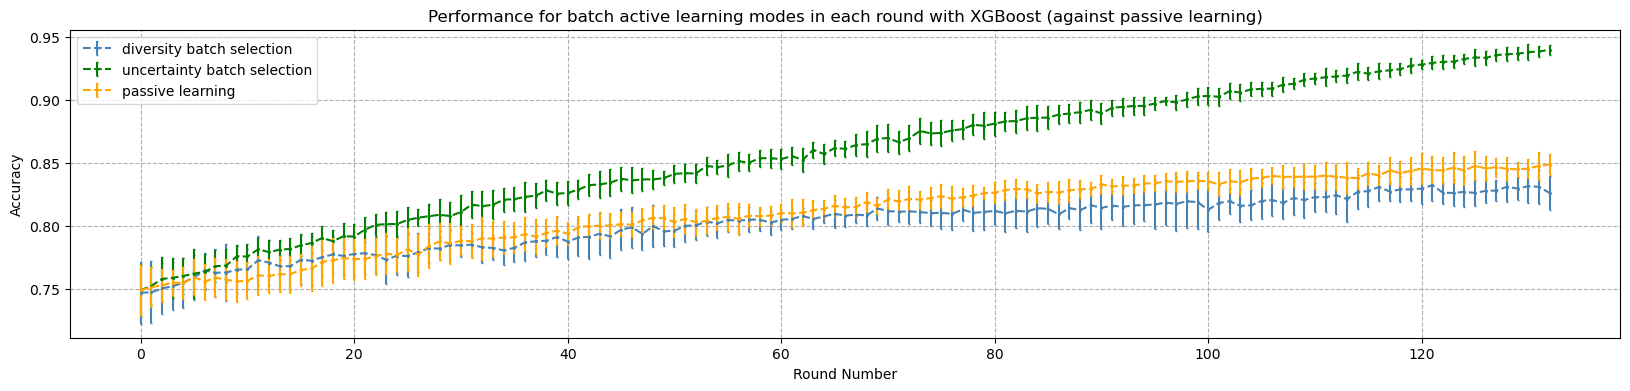

In [29]:
# get the result for uncertainty batch selection
test_mean_uncertainty_batch, test_std_uncertainty_batch, pts_uncertainty, certain_US = main_uncertainty()

# plot the results so far
plt.figure(figsize=(20, 4))

plt.errorbar(np.arange(test_mean_diversity_batch.shape[0]),
             test_mean_diversity_batch,
             yerr=test_std_diversity_batch,
             fmt='s',
             color='steelblue',
             ecolor='steelblue',
             linestyle='--',
             capsize=1,
             markersize=1,
             label='diversity batch selection')

plt.errorbar(np.arange(test_mean_uncertainty_batch.shape[0]),
             test_mean_uncertainty_batch,
             yerr=test_std_uncertainty_batch,
             fmt='s',
             color='green',
             ecolor='green',
             linestyle='--',
             capsize=1,
             markersize=1,
             label='uncertainty batch selection')

plt.errorbar(np.arange(test_mean_passive_batch.shape[0]),
             test_mean_passive_batch,
             yerr=test_std_passive_batch,
             fmt='s',
             color='orange',
             ecolor='orange',
             linestyle='--',
             capsize=1,
             markersize=1,
             label='passive learning')

# to display the legend
plt.legend()

# set up the characteristics of the plot

plt.xlabel('Round Number')
plt.ylabel('Accuracy')
plt.title('Performance for batch active learning modes in each round with XGBoost (against passive learning)')
plt.grid(True, linestyle='--')

# can save the fig to a folder
plt.show()


Single Batch Uncertainty Sampling

In [7]:
import threading
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import xgboost as xgb

INIT_SIZE = int(0.1*(y.shape[0]))
BATCH_SIZE = 3

# function to simulate a process that generates a float number based on a random seed
def process_SingleUC(random_seed):
    np.random.seed(random_seed)
    idices = list(range(y.shape[0]))
    np.random.shuffle(idices)

    # initialize
    train_idices = np.array(idices[:INIT_SIZE])
    test_idices = np.array(idices[INIT_SIZE:])

    test_uncertainty_single_per_seed = list()
    selected_list = list()
    selected_list = np.array(selected_list)
    most_certain = np.array([])

    batch_counter = -1

    while (float(len(train_idices))/len(test_idices) < 0.5):

        clf = xgb.XGBClassifier(random_state=random_seed)
        clf.fit(X[train_idices], np.ravel(y[train_idices]))
        y_pred = clf.predict(X[test_idices])
        if batch_counter == BATCH_SIZE or batch_counter == -1:
            batch_counter = 0
            test_uncertainty_single_per_seed.append(accuracy_score(np.ravel(y[test_idices]), y_pred))

        # select the next batch to mv from test to train
        # for uncertainty, selecte the most uncertain samples (lowest predicted prob)
        predicted_prob = clf.predict_proba(X[test_idices])
        sorted_pos = np.argsort(np.max(predicted_prob, axis=1))[0]
        most_certain_pos = np.argsort(np.max(predicted_prob, axis=1))[-1]
        elements_to_move = test_idices[sorted_pos]
    
        train_idices = np.append(train_idices, elements_to_move)
        selected_list = np.append(selected_list, elements_to_move)
        most_certain = np.append(most_certain, test_idices[most_certain_pos])
        
        test_idices = np.delete(test_idices, sorted_pos)
        batch_counter += 1

    return test_uncertainty_single_per_seed, selected_list, most_certain

# thread function to execute the process and append the result to a list
def thread_singleUC(seed, results, selected_dict, certain_dict, lock):
    result, selected_list, most_certain = process_SingleUC(seed)
    with lock:
        results.append(result)
        selected_dict[seed] = selected_list
        certain_dict[seed] = most_certain

def main_singleUC():
    num_threads = 10
    test_uncertainty_single_all = []
    threads = []
    selected_pts_dict = dict()
    certain_dict = dict()
    lock = threading.Lock()

    # create and start threads
    for i in range(num_threads):
        thread = threading.Thread(target=thread_singleUC, args=(i, test_uncertainty_single_all, 
                                                                   selected_pts_dict, certain_dict, lock))
        threads.append(thread)
        thread.start()

    # wait for all threads to complete
    for thread in threads:
        thread.join()

    # calculate and print the mean of the results
    test_uncertainty_single_all = np.array(test_uncertainty_single_all)
    test_mean_single_UC = np.mean(test_uncertainty_single_all, axis=0)
    test_std_single_UC = np.std(test_uncertainty_single_all, axis=0)
    return test_mean_single_UC, test_std_single_UC, selected_pts_dict, certain_dict



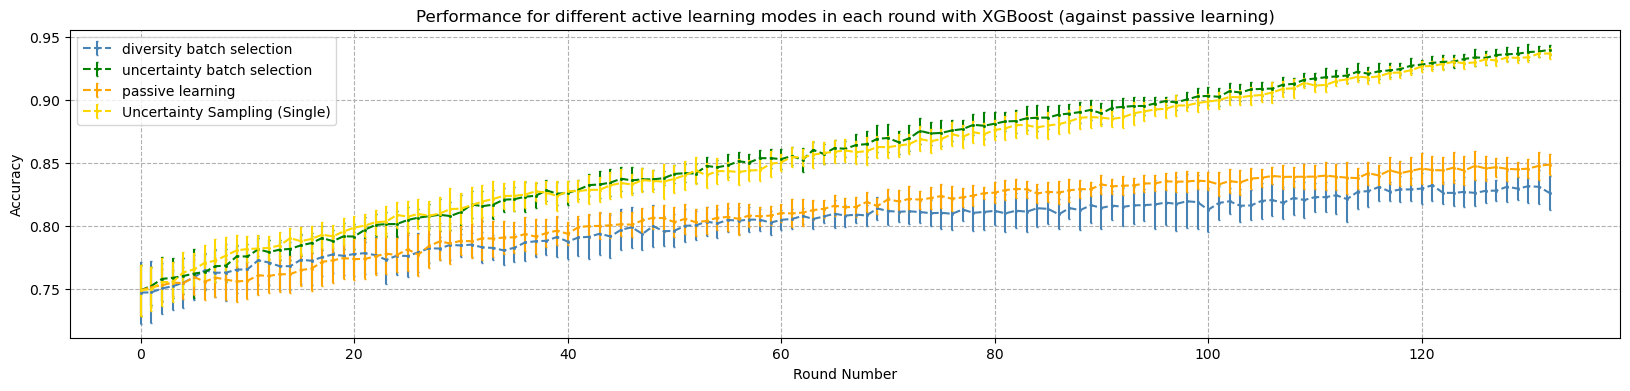

In [36]:
import pickle
import matplotlib.pyplot as plt

# obtain the results for single-mode uncertainty sampling
test_mean_singleUC, test_std_singleUC, pts_singleUC, certain_singleUC = main_singleUC()

# plot the results so far
plt.figure(figsize=(20, 4))


plt.errorbar(np.arange(test_mean_diversity_batch.shape[0]),
             test_mean_diversity_batch,
             yerr=test_std_diversity_batch,
             fmt='s',
             color='steelblue',
             ecolor='steelblue',
             linestyle='--',
             capsize=1,
             markersize=1,
             label='diversity batch selection')

plt.errorbar(np.arange(test_mean_uncertainty_batch.shape[0]),
             test_mean_uncertainty_batch,
             yerr=test_std_uncertainty_batch,
             fmt='s',
             color='green',
             ecolor='green',
             linestyle='--',
             capsize=1,
             markersize=1,
             label='uncertainty batch selection')

plt.errorbar(np.arange(test_mean_passive_batch.shape[0]),
             test_mean_passive_batch,
             yerr=test_std_passive_batch,
             fmt='s',
             color='orange',
             ecolor='orange',
             linestyle='--',
             capsize=1,
             markersize=1,
             label='passive learning')

plt.errorbar(np.arange(test_mean_singleUC.shape[0]),
             test_mean_singleUC,
             yerr=test_std_singleUC,
             fmt='s',
             color='gold',
             ecolor='gold',
             linestyle='--',
             capsize=1,
             markersize=1,
             label="Uncertainty Sampling (Single)")

# to display the legend
plt.legend()

# set up the characteristics of the plot

plt.xlabel('Round Number')
plt.ylabel('Accuracy')
plt.title('Performance for different active learning modes in each round with XGBoost (against passive learning)')
plt.grid(True, linestyle='--')

# can save the fig to a folder
plt.show()


explore why the diversity batch selection NOT works well: kMeans on the whole dataset

/home/yuxinl/miniconda3/envs/basicDA/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yuxinl/miniconda3/envs/basicDA/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yuxinl/miniconda3/envs/basicDA/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/yuxinl/miniconda3/envs/basicDA/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to su

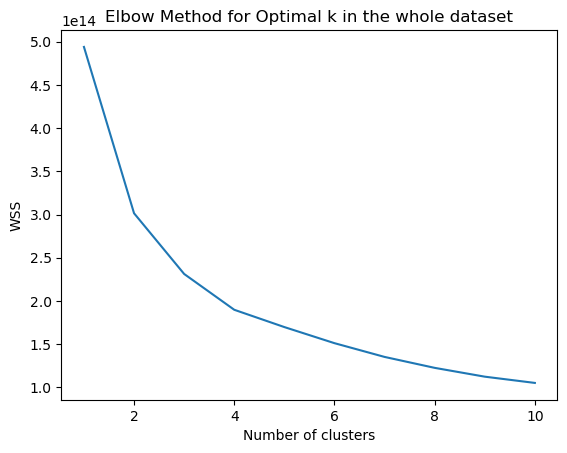

In [4]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans


# calculate WSS for different k values
wss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, max_iter=300, random_state=0)
    kmeans.fit(X)
    wss.append(kmeans.inertia_)

# Plotting the results
plt.plot(range(1, 11), wss)
plt.title('Elbow Method for Optimal k in the whole dataset')
plt.xlabel('Number of clusters')
plt.ylabel('WSS')
plt.show()
